In [33]:
#importing required libraries
from google.colab import drive
import pandas as pd
import seaborn as sns
import string 
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#mounting google drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
#reading the dataset 
#dataset: https://www.kaggle.com/uciml/sms-spam-collection-dataset
%cd '/content/gdrive/MyDrive/Gssoc'
msg=pd.read_csv("Spam SMS Collection",sep='\t',names=['label','text'])

/content/gdrive/MyDrive/Gssoc


In [35]:
#shape of dataframe
msg.shape

(5572, 2)

In [36]:
#mapping ham=0 and spam=1
for i in msg.index:
  if msg['label'][i]=='ham':
    msg['label'][i]=0
  else:
    msg['label'][i]=1
msg.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [37]:
#to examine spam texts and generate insights 
for i in range(50):
  if msg['label'][i]==1:
    print(msg['text'][i])

#from output, we observe that spam texts are more likely to contain numbers, emails, websites, symbols.

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or clic

In [38]:
#data description grouped by labels 
msg.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [39]:
#dropping duplicate columns 
msg=msg.drop_duplicates()
msg.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4516   4516                            Am in gobi arts college    1
1       653    653  URGENT! We are trying to contact you. Last wee...    1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


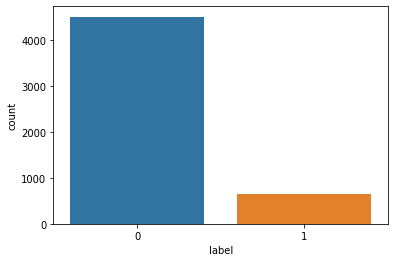

In [40]:
#category count plot (count of spam and ham)
sns.countplot(msg.label)

In [41]:
#adding length column to dataset 
msg['length']=msg['text'].apply(len)
print(msg.head())
print(msg.length.describe())

  label                                               text  length
0     0  Go until jurong point, crazy.. Available only ...     111
1     0                      Ok lar... Joking wif u oni...      29
2     1  Free entry in 2 a wkly comp to win FA Cup fina...     155
3     0  U dun say so early hor... U c already then say...      49
4     0  Nah I don't think he goes to usf, he lives aro...      61
count    5169.000000
mean       79.344554
std        58.437457
min         2.000000
25%        36.000000
50%        61.000000
75%       119.000000
max       910.000000
Name: length, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


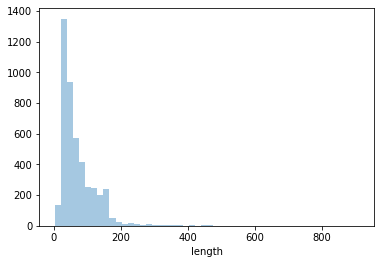

In [42]:
#plotting length graphs(ham)
sns.distplot(a=msg[msg['label']==0].length,kde=False)

#we observe that most of the ham texts have length less than 150

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


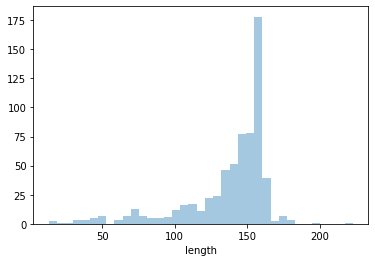

In [43]:
#plotting length graphs(spam)
sns.distplot(a=msg[msg['label']==1].length,kde=False)

#we observe that most of the spam texts have lenght around 150

In [44]:
#on basis of above generated insights, using regex to check for numbers,emails,websites,symbols. 
#added a new column called 'contain', if any of the above thing are present, contain=1 else contain=0
msg['contain']=msg['text'].str.contains('£').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('%').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('€').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('\$').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("T&C").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("www|WWW").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("http|HTTP").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("https|HTTPS").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("@").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("email|Email|EMAIL").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("SMS|sms|FREEPHONE").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{11}",regex=True).map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{10}",regex=True).map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{5}",regex=True).map({False:0,True:1})

msg.head()

,label,text,length,contain
0,0,"Go until jurong point, crazy.. Available only ...",111,0
1,0,Ok lar... Joking wif u oni...,29,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,0,U dun say so early hor... U c already then say...,49,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


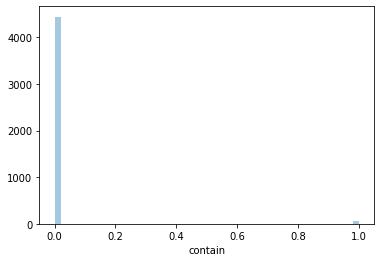

In [45]:
#graph for ham texts (on basis of contain column)
sns.distplot(a=msg[msg['label']==0].contain,kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


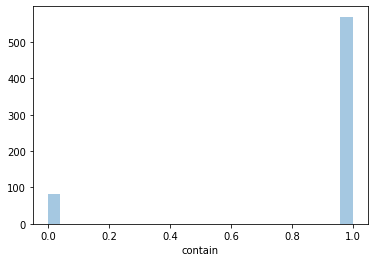

In [46]:
#graph for spam texts (on basis of contain column)
sns.distplot(a=msg[msg['label']==1].contain,kde=False)

In [47]:
#data cleaning/preprocessing - removing punctuation and digits 
msg['cleaned_text']=""

for i in msg.index:
  updated_list=[]
  for j in range(len(msg['text'][i])):
    if msg['text'][i][j] not in string.punctuation:
      if msg['text'][i][j].isdigit()==False:
        updated_list.append(msg['text'][i][j])
  updated_string="".join(updated_list)
  msg['cleaned_text'][i]=updated_string

msg.drop(['text'],axis=1,inplace=True)
msg.head() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,label,length,contain,cleaned_text
0,0,111,0,Go until jurong point crazy Available only in ...
1,0,29,0,Ok lar Joking wif u oni
2,1,155,1,Free entry in a wkly comp to win FA Cup final...
3,0,49,0,U dun say so early hor U c already then say
4,0,61,0,Nah I dont think he goes to usf he lives aroun...


In [48]:
#data clearning/preprocessing - tokenization and convert to lower case 
msg['token']=""

for i in msg.index:
  msg['token'][i]=re.split("\W+",msg['cleaned_text'][i].lower())

msg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,label,length,contain,cleaned_text,token
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [49]:
#data cleaning/preprocessing - stopwords
msg['updated_token']=""
stopwords=nltk.corpus.stopwords.words('english')

for i in msg.index:
  updated_list=[]
  for j in range(len(msg['token'][i])):
    if msg['token'][i][j] not in stopwords:
      updated_list.append(msg['token'][i][j])
  msg['updated_token'][i]=updated_list

msg.drop(['token'],axis=1,inplace=True)
msg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,label,length,contain,cleaned_text,updated_token
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, dont, think, goes, usf, lives, around, t..."


In [50]:
#data cleaning/preprocessing - lemmentizing
msg['lem_text']=""
wordlem=nltk.WordNetLemmatizer()

for i in msg.index:
  updated_list=[]
  for j in range(len(msg['updated_token'][i])):
    updated_list.append(wordlem.lemmatize(msg['updated_token'][i][j]))
  msg['lem_text'][i]=updated_list 

msg.drop(['updated_token'],axis=1,inplace=True)
msg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,label,length,contain,cleaned_text,lem_text
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, dont, think, go, usf, life, around, though]"


In [51]:
#data cleaning/preprocessing - mergining token
msg['final_text']=""

for i in msg.index:
  updated_string=" ".join(msg['lem_text'][i])
  msg['final_text'][i]=updated_string

msg.drop(['cleaned_text','lem_text'],axis=1,inplace=True)
msg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,length,contain,final_text
0,0,111,0,go jurong point crazy available bugis n great ...
1,0,29,0,ok lar joking wif u oni
2,1,155,1,free entry wkly comp win fa cup final tkts st ...
3,0,49,0,u dun say early hor u c already say
4,0,61,0,nah dont think go usf life around though


In [52]:
#seperating target and features
y=pd.DataFrame(msg.label)
x=msg.drop(['label'],axis=1)
print(x.head())
print(y.head())

   length  contain                                         final_text
0     111        0  go jurong point crazy available bugis n great ...
1      29        0                            ok lar joking wif u oni
2     155        1  free entry wkly comp win fa cup final tkts st ...
3      49        0                u dun say early hor u c already say
4      61        0           nah dont think go usf life around though
  label
0     0
1     0
2     1
3     0
4     0


In [53]:
#splitting the data 
x_train,x_val,y_train,y_val=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)
x_train.head()

,length,contain,final_text
3794,39,0,hey angry reply dr
4290,34,0,okay good problem thanx
2603,35,0,gonna get rimac access
3452,107,0,yes outside like hour called whole family wake...
3132,156,1,lookatme thanks purchase video clip lookatme y...


In [54]:
#countvectorization 
cv=CountVectorizer(max_features=5000)
temp1=cv.fit_transform(x_train['final_text']).toarray()
temp2=cv.transform(x_val['final_text']).toarray()

tf=TfidfTransformer()
temp1=tf.fit_transform(temp1)
temp2=tf.transform(temp2)

temp1=pd.DataFrame(temp1.toarray(),index=x_train.index)
temp2=pd.DataFrame(temp2.toarray(),index=x_val.index)

x_train=pd.concat([x_train,temp1],axis=1,sort=False)
x_val=pd.concat([x_val,temp2],axis=1,sort=False)

x_train.head()

,length,contain,final_text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
3794,39,0,hey angry reply dr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4290,34,0,okay good problem thanx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2603,35,0,gonna get rimac access,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3452,107,0,yes outside like hour called whole family wake...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3132,156,1,lookatme thanks purchase video clip lookatme y...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#drop final_text col
x_train.drop(['final_text'],axis=1,inplace=True)
x_val.drop(['final_text'],axis=1,inplace=True)

x_train.head()

,length,contain,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
3794,39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4290,34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2603,35,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3452,107,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3132,156,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#converting to int datatype
y_train=y_train.astype(int)
y_val=y_val.astype(int)
y_train.head()

,label
3794,0
4290,0
2603,0
3452,0
3132,1


In [57]:
#upsampling
smote=SMOTE(ratio='minority')
x_train_final,y_train_final=smote.fit_sample(x_train,y_train)
x_val_final,y_val_final=smote.fit_sample(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, 

In [58]:
#multinomial model
model=MultinomialNB()
model.fit(x_train_final,y_train_final)
y_preds=model.predict(x_val_final)
print(accuracy_score(y_val_final,y_preds))

0.9654017857142857


In [59]:
#decisiontree model
model=DecisionTreeClassifier(random_state=0)
model.fit(x_train_final,y_train_final)
y_preds=model.predict(x_val_final)
print(accuracy_score(y_val_final,y_preds))

0.9771205357142857


In [60]:
#randomforstclassifier model
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x_train_final,y_train_final)
y_preds=model.predict(x_val_final)
print(accuracy_score(y_val_final,y_preds))

0.9827008928571429


In [61]:
#preprocessing for k fold

cv=CountVectorizer(max_features=5000)
temp1=cv.fit_transform(x['final_text']).toarray()

tf=TfidfTransformer()
temp1=tf.fit_transform(temp1)
temp1=pd.DataFrame(temp1.toarray(),index=x.index)

x=pd.concat([x,temp1],axis=1,sort=False)

x.drop(['final_text'],axis=1,inplace=True)

y=y.astype(int)

smote=SMOTE(ratio='minority')
x,y=smote.fit_sample(x,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [62]:
#kfold
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
score=cross_val_score(RandomForestClassifier(n_estimators=100,random_state=0),x,y,cv=kf,scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}%".format(score.mean()*100)}')

Scores for each fold are: [0.99391256 0.99723298 0.9944629  0.99667774 0.99280177]
Average score: 99.50%


In [63]:
#cross validation
score=cross_val_score(RandomForestClassifier(n_estimators=100,random_state=0),x,y,cv=5,scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}%".format(score.mean()*100)}')

Scores for each fold are: [0.98007748 0.99778639 0.99778516 0.99889258 0.99833887]
Average score: 99.46%
